# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=78d022d8b8e3980aa43d6ab5ec687fff49094c43022670d194fa01214ce4abbc
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.2 MB/s eta 0:00:00


In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [44]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [45]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-46-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

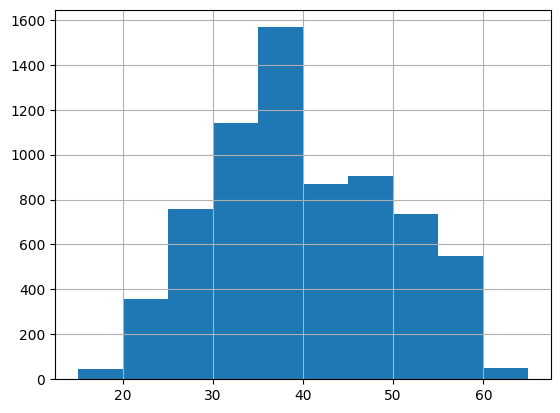

In [46]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [47]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [48]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [49]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [50]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [51]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [52]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [53]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [54]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [55]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [56]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [57]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [58]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [59]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

,count
Designation,
5,2330
1,2117
2,1632
3,635
4,264


<Axes: >

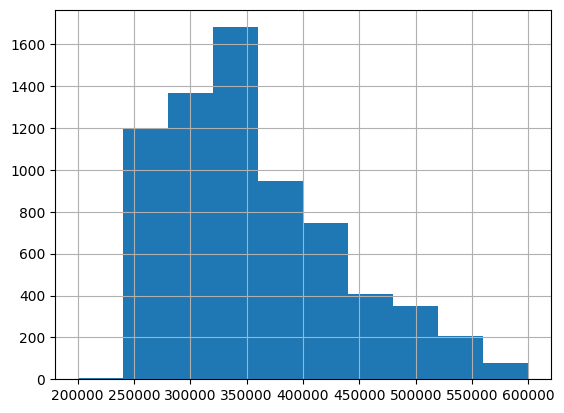

In [60]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [61]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [62]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [63]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [64]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [65]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [66]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [67]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

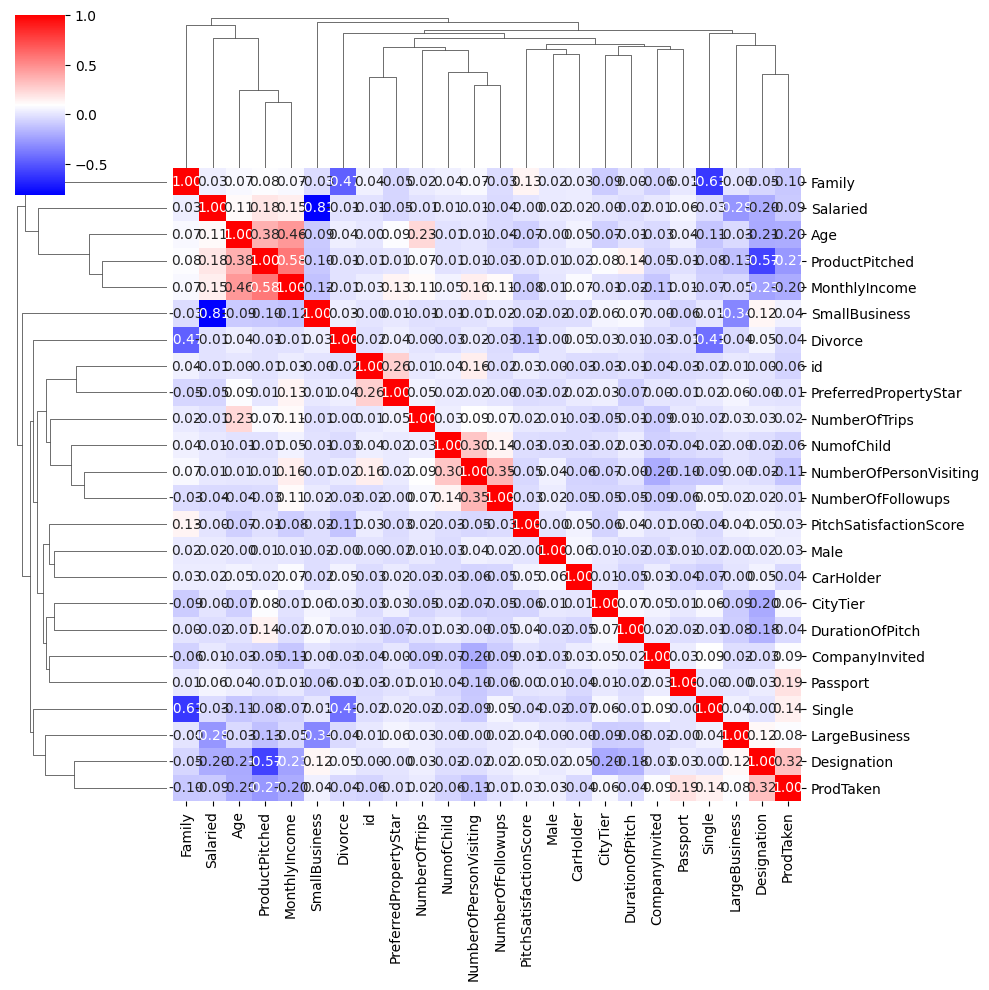

In [68]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [69]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [70]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

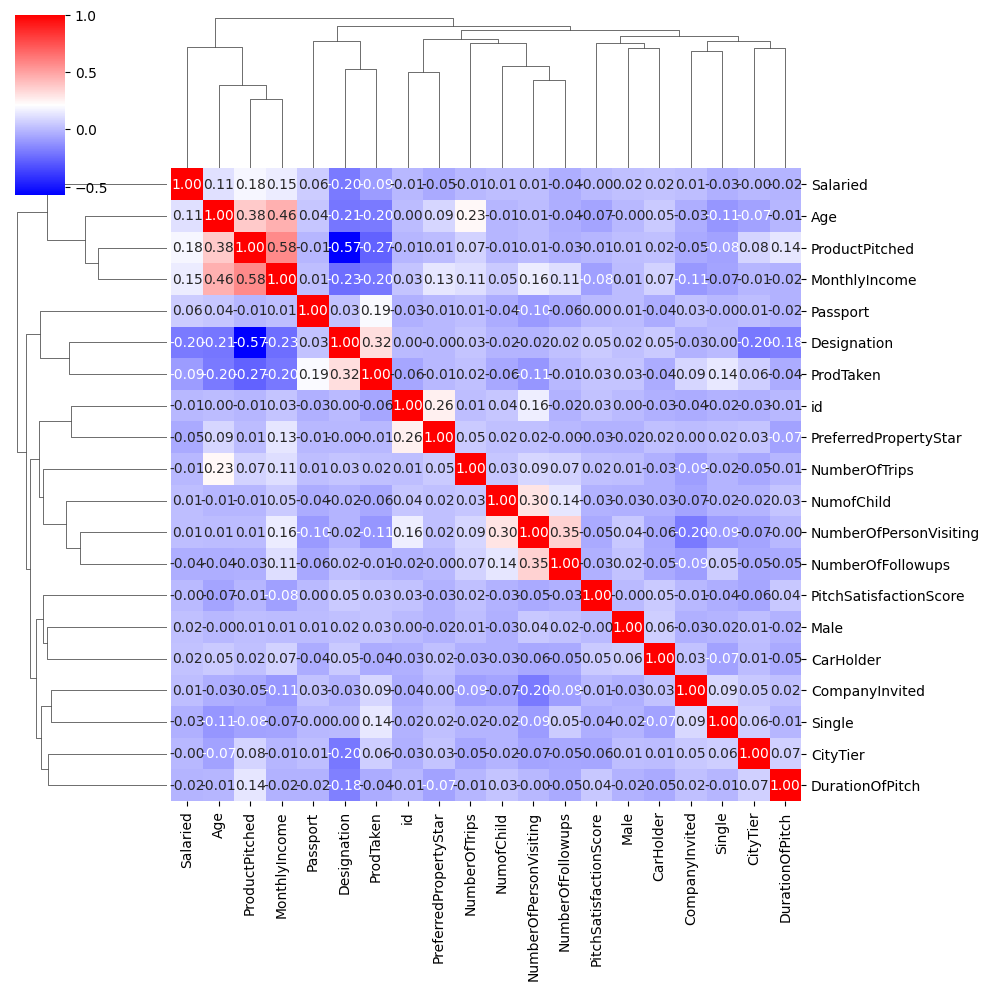

In [71]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [72]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [73]:
# クロス特徴量
# 「役職」x「商品ランク」追加
all_df["Designation_ProductPitched"] = all_df["Designation"] * all_df["ProductPitched"]
# 削除
all_df = all_df.drop("Salaried", axis=1)

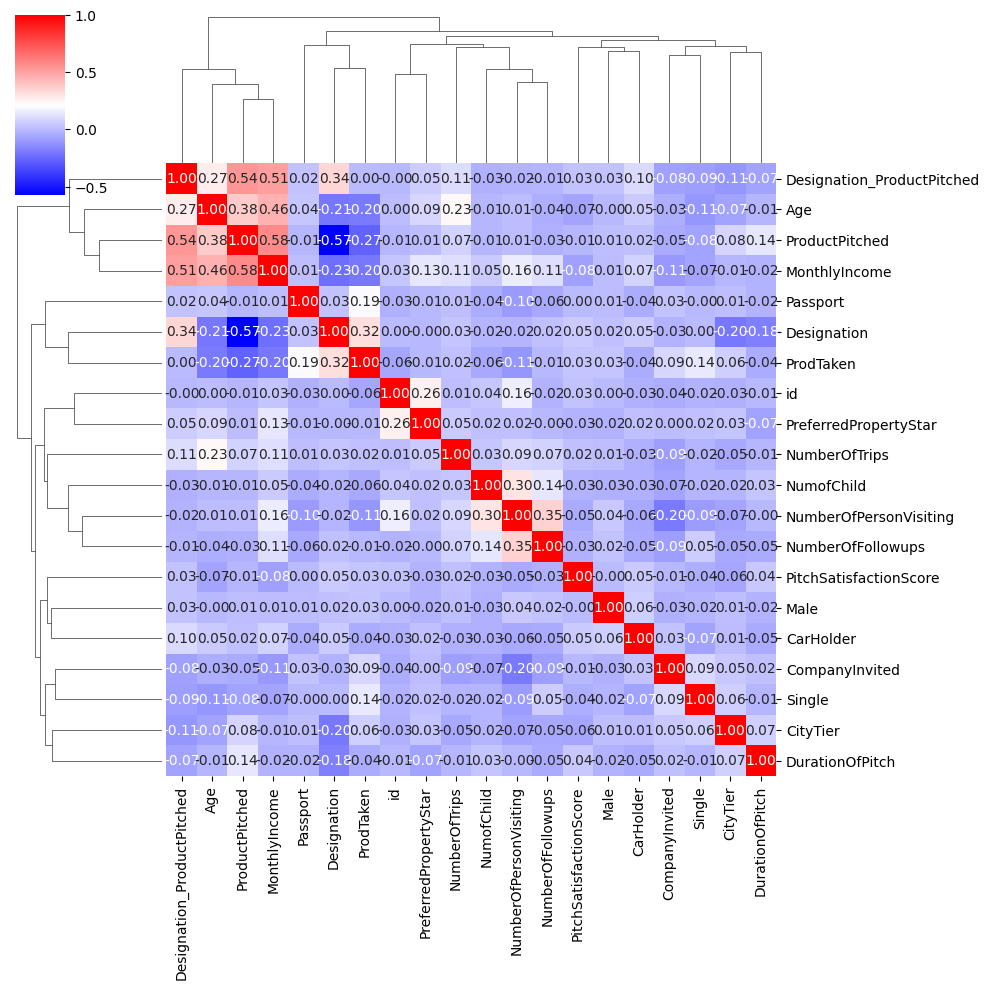

In [74]:
# 相関係数の確認OK
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [92]:
# テスト用のダミー追加
all_df2 = all_df.copy()
all_df2 = all_df.drop("DurationOfPitch", axis=1)

In [93]:
# 「商品ランク」x「独身」追加
all_df2["ProductPitched_Single"] = all_df2["ProductPitched"] * all_df2["Single"]

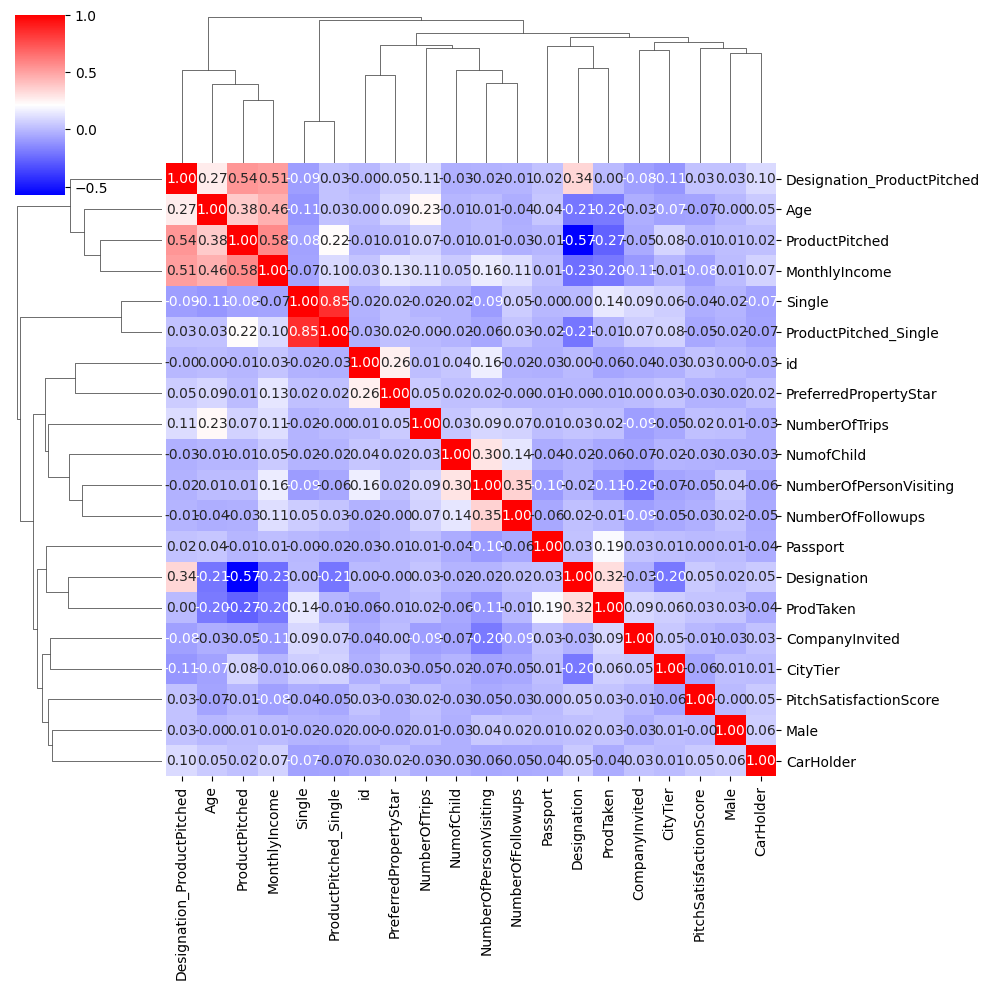

In [94]:
# 相関係数の確認OK
all_df2_corr = all_df2.corr()
sns.clustermap(all_df2_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("Occupation_LE", axis=1)

In [ ]:
# 月収、年齢はLogを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 元の列削除
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

# ここから学習作業

In [95]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df2.columns if c not in RMV2]
TARGET = "ProdTaken"

In [97]:
CATS = []
for c in FEATURES:
  if all_df2[c].dtype == "object":
    CATS.append(c)
print(CATS)

[]


In [98]:
# オブジェクト型はint型に変換する
all_df2[CATS] = all_df2[CATS].astype(int)

In [99]:
# カラムを制限
all_df3 = all_df2[FEATURES]

# 結合を戻す
train = all_df3.iloc[:len(train_df)].copy()
test = all_df3.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [100]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.1,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-25 11:25:00,710] A new study created in memory with name: no-name-51324677-2746-415b-93f2-3bd477b9c4bd
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.954004	valid's auc: 0.813857
#########################
### Fold 2
#########################
[100]	train's auc: 0.957705	valid's auc: 0.795688
#########################
### Fold 3
#########################
[100]	train's auc: 0.951946	valid's auc: 0.814581


[I 2025-05-25 11:25:02,486] Trial 0 finished with value: 0.8250034969173329 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 67, 'feature_fraction': 0.6466469035612737, 'bagging_fraction': 0.756922556073532, 'bagging_freq': 3, 'lambda_l1': 0.00013313011552100262, 'lambda_l2': 8.091965482811892e-05, 'max_depth': 8}. Best is trial 0 with value: 0.8250034969173329.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.903063	valid's auc: 0.823984
#########################
### Fold 2
#########################
[100]	train's auc: 0.91207	valid's auc: 0.802305
#########################
### Fold 3
#########################
[100]	train's auc: 0.903714	valid's auc: 0.825165


[I 2025-05-25 11:25:02,954] Trial 1 finished with value: 0.8210573602040048 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 75, 'feature_fraction': 0.8143855380255363, 'bagging_fraction': 0.6716843051522132, 'bagging_freq': 5, 'lambda_l1': 1.1131039675719337e-06, 'lambda_l2': 6.749647145107897e-05, 'max_depth': 4}. Best is trial 0 with value: 0.8250034969173329.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.996102	valid's auc: 0.800987
#########################
### Fold 2
#########################
[100]	train's auc: 0.996971	valid's auc: 0.7708
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:03,728] Trial 2 finished with value: 0.8113564407837398 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 20, 'feature_fraction': 0.869351809677057, 'bagging_fraction': 0.6400532878523018, 'bagging_freq': 2, 'lambda_l1': 0.0004439640238977201, 'lambda_l2': 0.4590508204478628, 'max_depth': 10}. Best is trial 0 with value: 0.8250034969173329.


[100]	train's auc: 0.994674	valid's auc: 0.794698
#########################
### Fold 1
#########################
[100]	train's auc: 0.937726	valid's auc: 0.811954
#########################
### Fold 2
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.950035	valid's auc: 0.798371
#########################
### Fold 3
#########################
[100]	train's auc: 0.943002	valid's auc: 0.814866


[I 2025-05-25 11:25:04,247] Trial 3 finished with value: 0.8231713139801375 and parameters: {'num_leaves': 248, 'min_data_in_leaf': 63, 'feature_fraction': 0.6470108872474117, 'bagging_fraction': 0.5893197371353284, 'bagging_freq': 5, 'lambda_l1': 9.855747223092345e-08, 'lambda_l2': 1.017284292593712e-06, 'max_depth': 10}. Best is trial 0 with value: 0.8250034969173329.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.969202	valid's auc: 0.816951
#########################
### Fold 2
#########################
[100]	train's auc: 0.971344	valid's auc: 0.786764
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:04,860] Trial 4 finished with value: 0.8106621009479336 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 28, 'feature_fraction': 0.6432991951944663, 'bagging_fraction': 0.8691043128614693, 'bagging_freq': 3, 'lambda_l1': 1.409613031821353, 'lambda_l2': 4.235721132408009e-08, 'max_depth': 9}. Best is trial 0 with value: 0.8250034969173329.


[100]	train's auc: 0.969895	valid's auc: 0.813627
#########################
### Fold 1
#########################
[100]	train's auc: 0.903122	valid's auc: 0.835223


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.911486	valid's auc: 0.797175
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:05,403] Trial 5 finished with value: 0.8301843144428066 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 97, 'feature_fraction': 0.7709516845688862, 'bagging_fraction': 0.5363466808808742, 'bagging_freq': 3, 'lambda_l1': 7.959316847520615e-06, 'lambda_l2': 2.504587476929734e-07, 'max_depth': 6}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.895634	valid's auc: 0.830358
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.937106	valid's auc: 0.822419
#########################
### Fold 2
#########################
[100]	train's auc: 0.942847	valid's auc: 0.796691
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:06,090] Trial 6 finished with value: 0.8197480336564843 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 25, 'feature_fraction': 0.8810527970070563, 'bagging_fraction': 0.8677266704020213, 'bagging_freq': 3, 'lambda_l1': 3.0179185853416155, 'lambda_l2': 0.0015858837945401877, 'max_depth': 12}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.935655	valid's auc: 0.826386
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.915078	valid's auc: 0.822987
#########################
### Fold 2
#########################
[100]	train's auc: 0.925743	valid's auc: 0.792063
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:06,536] Trial 7 finished with value: 0.8198569760810854 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 42, 'feature_fraction': 0.854458872521248, 'bagging_fraction': 0.6017354318209817, 'bagging_freq': 6, 'lambda_l1': 2.3976867776526637e-07, 'lambda_l2': 0.0018386161505186144, 'max_depth': 4}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.911749	valid's auc: 0.818753
#########################
### Fold 1
#########################
[100]	train's auc: 0.985718	valid's auc: 0.802842


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.984947	valid's auc: 0.783616
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:07,129] Trial 8 finished with value: 0.81013958080031 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 21, 'feature_fraction': 0.8374784980816683, 'bagging_fraction': 0.9420101768785765, 'bagging_freq': 1, 'lambda_l1': 9.151015003815292e-07, 'lambda_l2': 1.0564500494505016e-08, 'max_depth': 6}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.986894	valid's auc: 0.808775
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.999032	valid's auc: 0.790607
#########################
### Fold 2
#########################
[100]	train's auc: 0.999091	valid's auc: 0.764057
#########################
### Fold 3
#########################
[100]	train's auc: 0.998338	valid's auc: 0.793666


[I 2025-05-25 11:25:08,173] Trial 9 finished with value: 0.7867455400854323 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 11, 'feature_fraction': 0.7718532702998528, 'bagging_fraction': 0.6414377063252441, 'bagging_freq': 7, 'lambda_l1': 4.082916773858979e-08, 'lambda_l2': 0.10215263629484245, 'max_depth': 9}. Best is trial 5 with value: 0.8301843144428066.


[200]	train's auc: 1	valid's auc: 0.779996
#########################
### Fold 1
#########################
[100]	train's auc: 0.906166	valid's auc: 0.839488


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.916058	valid's auc: 0.803084
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:08,734] Trial 10 finished with value: 0.8266658776186531 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 100, 'feature_fraction': 0.9995784126370684, 'bagging_fraction': 0.5448293821649047, 'bagging_freq': 1, 'lambda_l1': 0.0007673893498965844, 'lambda_l2': 6.04889408282691e-07, 'max_depth': 6}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.901945	valid's auc: 0.831354
#########################
### Fold 1
#########################
[100]	train's auc: 0.903979	valid's auc: 0.837216


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.910952	valid's auc: 0.802818
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:09,267] Trial 11 finished with value: 0.8261194842853914 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 99, 'feature_fraction': 0.99825881203935, 'bagging_fraction': 0.5036789117629564, 'bagging_freq': 1, 'lambda_l1': 0.0004545658967456575, 'lambda_l2': 1.6012497440594338e-06, 'max_depth': 6}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.89913	valid's auc: 0.828281
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.891752	valid's auc: 0.834443
#########################
### Fold 2
#########################
[100]	train's auc: 0.90366	valid's auc: 0.802981
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:09,786] Trial 12 finished with value: 0.8285041129127708 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 98, 'feature_fraction': 0.5001138792305722, 'bagging_fraction': 0.5253643065450593, 'bagging_freq': 2, 'lambda_l1': 0.021281285880965162, 'lambda_l2': 6.106790755429196e-07, 'max_depth': 6}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.890603	valid's auc: 0.826398
#########################
### Fold 1
#########################
[100]	train's auc: 0.877418	valid's auc: 0.836195


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.892466	valid's auc: 0.805175
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:10,325] Trial 13 finished with value: 0.8286251600512163 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 82, 'feature_fraction': 0.5531525608817913, 'bagging_fraction': 0.721949725161956, 'bagging_freq': 4, 'lambda_l1': 0.028932282177489926, 'lambda_l2': 7.658350658544971e-06, 'max_depth': 3}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.881059	valid's auc: 0.831263
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.881295	valid's auc: 0.834328
#########################
### Fold 2
#########################
[100]	train's auc: 0.892769	valid's auc: 0.804033
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:10,785] Trial 14 finished with value: 0.8276527480390363 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 84, 'feature_fraction': 0.5097079184420568, 'bagging_fraction': 0.7680665023911173, 'bagging_freq': 4, 'lambda_l1': 1.1095801986159423e-05, 'lambda_l2': 3.1964866893070906e-05, 'max_depth': 3}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.88082	valid's auc: 0.832198
#########################
### Fold 1
#########################
[100]	train's auc: 0.879416	valid's auc: 0.830504


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.888749	valid's auc: 0.803344
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:11,263] Trial 15 finished with value: 0.828900206049129 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 88, 'feature_fraction': 0.7118163906922983, 'bagging_fraction': 0.7176789745657568, 'bagging_freq': 4, 'lambda_l1': 0.056026624726015814, 'lambda_l2': 1.2411412008330571e-05, 'max_depth': 3}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.878297	valid's auc: 0.833267
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.938561	valid's auc: 0.815815
#########################
### Fold 2
#########################
[100]	train's auc: 0.946796	valid's auc: 0.788842
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:11,804] Trial 16 finished with value: 0.8203492344440979 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 47, 'feature_fraction': 0.726927126083397, 'bagging_fraction': 0.8110762039144052, 'bagging_freq': 5, 'lambda_l1': 0.04345394556099708, 'lambda_l2': 6.25685908643796e-08, 'max_depth': 5}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.94212	valid's auc: 0.812249
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.923749	valid's auc: 0.827996
#########################
### Fold 2
#########################
[100]	train's auc: 0.931692	valid's auc: 0.7917
#########################
### Fold 3
#########################
[100]	train's auc: 0.921175	valid's auc: 0.8229


[I 2025-05-25 11:25:13,984] Trial 17 finished with value: 0.826528690861748 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 88, 'feature_fraction': 0.7153478174581469, 'bagging_fraction': 0.7025920311829625, 'bagging_freq': 4, 'lambda_l1': 3.001163288699828e-05, 'lambda_l2': 0.0010368643567944301, 'max_depth': 7}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.896133	valid's auc: 0.835984
#########################
### Fold 2
#########################
[100]	train's auc: 0.904838	valid's auc: 0.801712
#########################
### Fold 3
#########################
[100]	train's auc: 0.896114	valid's auc: 0.824582


[I 2025-05-25 11:25:14,549] Trial 18 finished with value: 0.8236702971841745 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 72, 'feature_fraction': 0.9387450940231507, 'bagging_fraction': 0.9543582686468557, 'bagging_freq': 2, 'lambda_l1': 0.005162198853363168, 'lambda_l2': 8.90145391024769, 'max_depth': 4}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.914838	valid's auc: 0.811042
#########################
### Fold 2
#########################


[I 2025-05-25 11:25:14,997] Trial 19 finished with value: 0.8194467607785753 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 59, 'feature_fraction': 0.6918010232235933, 'bagging_fraction': 0.5846857420208279, 'bagging_freq': 6, 'lambda_l1': 0.3764892880368322, 'lambda_l2': 1.273523388800539e-07, 'max_depth': 5}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.924374	valid's auc: 0.796462
#########################
### Fold 3
#########################
[100]	train's auc: 0.9118	valid's auc: 0.818637
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893236	valid's auc: 0.834504
#########################
### Fold 2
#########################
[100]	train's auc: 0.903972	valid's auc: 0.796347
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:15,448] Trial 20 finished with value: 0.825014929147075 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 50, 'feature_fraction': 0.763030645444017, 'bagging_fraction': 0.8287397255977799, 'bagging_freq': 3, 'lambda_l1': 1.2342018841021596e-08, 'lambda_l2': 0.017231459532276918, 'max_depth': 3}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.89403	valid's auc: 0.827115
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878433	valid's auc: 0.835664
#########################
### Fold 2
#########################
[100]	train's auc: 0.891125	valid's auc: 0.804933
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:15,945] Trial 21 finished with value: 0.8289731705742476 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 86, 'feature_fraction': 0.5804973847753799, 'bagging_fraction': 0.7263399989319411, 'bagging_freq': 4, 'lambda_l1': 0.14238880658850897, 'lambda_l2': 9.223192182387588e-06, 'max_depth': 3}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.87742	valid's auc: 0.835422
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.915617	valid's auc: 0.830842
#########################
### Fold 2
#########################
[100]	train's auc: 0.930035	valid's auc: 0.796785
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:16,440] Trial 22 finished with value: 0.8236302843800773 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 90, 'feature_fraction': 0.5954034935830251, 'bagging_fraction': 0.999193255505642, 'bagging_freq': 4, 'lambda_l1': 0.22782656296012316, 'lambda_l2': 1.0150400138033235e-05, 'max_depth': 5}. Best is trial 5 with value: 0.8301843144428066.


[100]	train's auc: 0.921046	valid's auc: 0.821504
#########################
### Fold 1
#########################
[100]	train's auc: 0.850927	valid's auc: 0.838449


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.859861	valid's auc: 0.840703
[300]	train's auc: 0.863942	valid's auc: 0.839434
#########################
### Fold 2
#########################
[100]	train's auc: 0.869583	valid's auc: 0.808111
[200]	train's auc: 0.872554	valid's auc: 0.810462
#########################
### Fold 3
#########################
[100]	train's auc: 0.85582	valid's auc: 0.83552
[200]	train's auc: 0.860021	valid's auc: 0.836437


[I 2025-05-25 11:25:17,113] Trial 23 finished with value: 0.8275730586728929 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 76, 'feature_fraction': 0.5990886091664109, 'bagging_fraction': 0.6951647837663693, 'bagging_freq': 4, 'lambda_l1': 7.367833567236492, 'lambda_l2': 6.8975578045298145e-06, 'max_depth': 3}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897909	valid's auc: 0.832528
#########################
### Fold 2
#########################
[100]	train's auc: 0.9161	valid's auc: 0.796806
#########################
### Fold 3
#########################
[100]	train's auc: 0.899941	valid's auc: 0.831357


[I 2025-05-25 11:25:17,664] Trial 24 finished with value: 0.8272953227385705 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 91, 'feature_fraction': 0.8080664595873143, 'bagging_fraction': 0.7817976839243936, 'bagging_freq': 5, 'lambda_l1': 0.0032014673045762834, 'lambda_l2': 0.0001670294954452595, 'max_depth': 4}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.918832	valid's auc: 0.830286
#########################
### Fold 2
#########################
[100]	train's auc: 0.926195	valid's auc: 0.803072
#########################
### Fold 3
#########################
[100]	train's auc: 0.918406	valid's auc: 0.8287


[I 2025-05-25 11:25:18,222] Trial 25 finished with value: 0.827105345979621 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 81, 'feature_fraction': 0.701915005319725, 'bagging_fraction': 0.6550930507279809, 'bagging_freq': 3, 'lambda_l1': 0.34802747755309876, 'lambda_l2': 2.4939774682905956e-06, 'max_depth': 7}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.893722	valid's auc: 0.840872
#########################
### Fold 2
#########################
[100]	train's auc: 0.903958	valid's auc: 0.801984
#########################
### Fold 3
#########################
[100]	train's auc: 0.894442	valid's auc: 0.830862


[I 2025-05-25 11:25:18,773] Trial 26 finished with value: 0.829958696026426 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 94, 'feature_fraction': 0.5638187682591829, 'bagging_fraction': 0.5532849653697096, 'bagging_freq': 6, 'lambda_l1': 7.619493635201128e-06, 'lambda_l2': 2.144194345866948e-05, 'max_depth': 5}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.894046	valid's auc: 0.830606
#########################
### Fold 2
#########################
[100]	train's auc: 0.900023	valid's auc: 0.80567
#########################
### Fold 3
#########################
[100]	train's auc: 0.894187	valid's auc: 0.825991


[I 2025-05-25 11:25:19,309] Trial 27 finished with value: 0.8264046175448414 and parameters: {'num_leaves': 202, 'min_data_in_leaf': 94, 'feature_fraction': 0.5642834351391741, 'bagging_fraction': 0.5658113254232413, 'bagging_freq': 7, 'lambda_l1': 6.138490948494152e-06, 'lambda_l2': 2.3721909915268551e-07, 'max_depth': 5}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.904021	valid's auc: 0.834594
#########################
### Fold 2
#########################
[100]	train's auc: 0.911931	valid's auc: 0.793906
#########################
### Fold 3
#########################
[100]	train's auc: 0.905027	valid's auc: 0.834997


[I 2025-05-25 11:25:19,890] Trial 28 finished with value: 0.8268289550135035 and parameters: {'num_leaves': 224, 'min_data_in_leaf': 81, 'feature_fraction': 0.541892162562264, 'bagging_fraction': 0.510730828590324, 'bagging_freq': 6, 'lambda_l1': 5.961229161469154e-05, 'lambda_l2': 1.3300632438531785e-08, 'max_depth': 7}. Best is trial 5 with value: 0.8301843144428066.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.909002	valid's auc: 0.835567
#########################
### Fold 2
#########################
[100]	train's auc: 0.919447	valid's auc: 0.806196
#########################
### Fold 3
#########################
[100]	train's auc: 0.910671	valid's auc: 0.83275


[I 2025-05-25 11:25:20,468] Trial 29 finished with value: 0.8304997094868676 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 95, 'feature_fraction': 0.657414292084532, 'bagging_fraction': 0.6018532895118581, 'bagging_freq': 2, 'lambda_l1': 3.056737130321294e-06, 'lambda_l2': 0.00046640087822305917, 'max_depth': 8}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.931201	valid's auc: 0.825507
#########################
### Fold 2
#########################
[100]	train's auc: 0.941465	valid's auc: 0.793256
#########################
### Fold 3
#########################
[100]	train's auc: 0.933297	valid's auc: 0.819566


[I 2025-05-25 11:25:21,112] Trial 30 finished with value: 0.8224581445894619 and parameters: {'num_leaves': 246, 'min_data_in_leaf': 71, 'feature_fraction': 0.6492049436023473, 'bagging_fraction': 0.6099709845461236, 'bagging_freq': 2, 'lambda_l1': 2.1601423748987846e-06, 'lambda_l2': 0.0004896133850938324, 'max_depth': 8}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.903122	valid's auc: 0.834286
#########################
### Fold 2
#########################
[100]	train's auc: 0.913565	valid's auc: 0.800637
#########################
### Fold 3
#########################
[100]	train's auc: 0.901899	valid's auc: 0.829823


[I 2025-05-25 11:25:21,690] Trial 31 finished with value: 0.8285656452081473 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 94, 'feature_fraction': 0.6154402848472086, 'bagging_fraction': 0.5509790479590579, 'bagging_freq': 2, 'lambda_l1': 6.963701139231324e-05, 'lambda_l2': 0.005802189976183589, 'max_depth': 8}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.9094	valid's auc: 0.829362
#########################
### Fold 2
#########################
[100]	train's auc: 0.916589	valid's auc: 0.805906
#########################
### Fold 3
#########################
[100]	train's auc: 0.909083	valid's auc: 0.830686


[I 2025-05-25 11:25:22,274] Trial 32 finished with value: 0.8288625469393904 and parameters: {'num_leaves': 214, 'min_data_in_leaf': 94, 'feature_fraction': 0.5695412031524475, 'bagging_fraction': 0.6253931668581764, 'bagging_freq': 3, 'lambda_l1': 7.601274740958808e-06, 'lambda_l2': 2.9026143778028254e-05, 'max_depth': 7}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929217	valid's auc: 0.834262
#########################
### Fold 2
#########################
[100]	train's auc: 0.941041	valid's auc: 0.800341
#########################
### Fold 3
#########################
[100]	train's auc: 0.934779	valid's auc: 0.822002


[I 2025-05-25 11:25:22,868] Trial 33 finished with value: 0.8270596170606526 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 77, 'feature_fraction': 0.6716928604155581, 'bagging_fraction': 0.6695915132435486, 'bagging_freq': 2, 'lambda_l1': 6.21667028933092e-07, 'lambda_l2': 9.04241929410676e-05, 'max_depth': 8}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.909964	valid's auc: 0.826201
#########################
### Fold 2
#########################
[100]	train's auc: 0.91732	valid's auc: 0.804709
#########################
### Fold 3
#########################
[100]	train's auc: 0.91208	valid's auc: 0.827837


[I 2025-05-25 11:25:23,415] Trial 34 finished with value: 0.8225667507720118 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 86, 'feature_fraction': 0.621060672755652, 'bagging_fraction': 0.5704093004627795, 'bagging_freq': 5, 'lambda_l1': 0.00017775425061780257, 'lambda_l2': 5.480955784680295e-05, 'max_depth': 9}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89756	valid's auc: 0.832129
#########################
### Fold 2
#########################
[100]	train's auc: 0.907875	valid's auc: 0.793302


[I 2025-05-25 11:25:25,555] Trial 35 finished with value: 0.8271144245150044 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 66, 'feature_fraction': 0.6742290522143937, 'bagging_fraction': 0.5431120824061182, 'bagging_freq': 3, 'lambda_l1': 2.1752319959124707e-05, 'lambda_l2': 0.000286075931081669, 'max_depth': 4}. Best is trial 29 with value: 0.8304997094868676.


#########################
### Fold 3
#########################
[100]	train's auc: 0.894414	valid's auc: 0.829052


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.975228	valid's auc: 0.80451
#########################
### Fold 2
#########################
[100]	train's auc: 0.977716	valid's auc: 0.779151
#########################
### Fold 3
#########################
[100]	train's auc: 0.974676	valid's auc: 0.804142


[I 2025-05-25 11:25:26,315] Trial 36 finished with value: 0.8134246656409043 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 36, 'feature_fraction': 0.5315855823800714, 'bagging_fraction': 0.600011402062508, 'bagging_freq': 6, 'lambda_l1': 2.7375425926207294e-06, 'lambda_l2': 3.66406466647863e-06, 'max_depth': 12}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930601	valid's auc: 0.828153
#########################
### Fold 2
#########################
[100]	train's auc: 0.938146	valid's auc: 0.799779
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:26,992] Trial 37 finished with value: 0.8268935134873412 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 95, 'feature_fraction': 0.7886576763709189, 'bagging_fraction': 0.7479488419669815, 'bagging_freq': 3, 'lambda_l1': 6.387363277728874e-07, 'lambda_l2': 0.00977686825411833, 'max_depth': 10}. Best is trial 29 with value: 0.8304997094868676.


[100]	train's auc: 0.929727	valid's auc: 0.824898
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.930538	valid's auc: 0.826383
#########################
### Fold 2
#########################
[100]	train's auc: 0.938066	valid's auc: 0.800758


[I 2025-05-25 11:25:27,585] Trial 38 finished with value: 0.8271725943898686 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 78, 'feature_fraction': 0.7399378977585829, 'bagging_fraction': 0.6218892236369159, 'bagging_freq': 3, 'lambda_l1': 2.5552540599635445e-07, 'lambda_l2': 5.051073641146362e-07, 'max_depth': 11}. Best is trial 29 with value: 0.8304997094868676.


#########################
### Fold 3
#########################
[100]	train's auc: 0.927643	valid's auc: 0.830109


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.911174	valid's auc: 0.819144
#########################
### Fold 2
#########################


[I 2025-05-25 11:25:28,114] Trial 39 finished with value: 0.8251625394075685 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 71, 'feature_fraction': 0.5838618822566645, 'bagging_fraction': 0.521812060836854, 'bagging_freq': 5, 'lambda_l1': 0.001451532106602049, 'lambda_l2': 0.0001464061672809304, 'max_depth': 6}. Best is trial 29 with value: 0.8304997094868676.


[100]	train's auc: 0.920552	valid's auc: 0.798292
#########################
### Fold 3
#########################
[100]	train's auc: 0.911403	valid's auc: 0.821267


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.912105	valid's auc: 0.837561
#########################
### Fold 2
#########################
[100]	train's auc: 0.925618	valid's auc: 0.803936
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:28,725] Trial 40 finished with value: 0.8298591683792595 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 100, 'feature_fraction': 0.6292168174491818, 'bagging_fraction': 0.677755414833484, 'bagging_freq': 1, 'lambda_l1': 1.1367863503410465e-07, 'lambda_l2': 0.035890614408075, 'max_depth': 9}. Best is trial 29 with value: 0.8304997094868676.


[100]	train's auc: 0.914049	valid's auc: 0.830242
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908748	valid's auc: 0.837204
#########################
### Fold 2
#########################
[100]	train's auc: 0.92115	valid's auc: 0.802371
#########################
### Fold 3
#########################
[100]	train's auc: 0.909771	valid's auc: 0.828894


[I 2025-05-25 11:25:29,383] Trial 41 finished with value: 0.8275700324944318 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 99, 'feature_fraction': 0.6381032762405908, 'bagging_fraction': 0.6754299603164364, 'bagging_freq': 1, 'lambda_l1': 5.738973751903785e-08, 'lambda_l2': 0.6359281819946763, 'max_depth': 9}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929455	valid's auc: 0.831047
#########################
### Fold 2
#########################
[100]	train's auc: 0.939963	valid's auc: 0.796039
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:30,017] Trial 42 finished with value: 0.8277986770892737 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 92, 'feature_fraction': 0.6740523471716546, 'bagging_fraction': 0.7436761025827522, 'bagging_freq': 1, 'lambda_l1': 1.2690655031580652e-08, 'lambda_l2': 0.07927246337485774, 'max_depth': 10}. Best is trial 29 with value: 0.8304997094868676.


[100]	train's auc: 0.929175	valid's auc: 0.823957
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911004	valid's auc: 0.83005
#########################
### Fold 2
#########################
[100]	train's auc: 0.920944	valid's auc: 0.798072
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:30,558] Trial 43 finished with value: 0.829648008371082 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 97, 'feature_fraction': 0.6168248587433549, 'bagging_fraction': 0.6396003303840131, 'bagging_freq': 2, 'lambda_l1': 1.5414917209595028e-07, 'lambda_l2': 0.04345558650954857, 'max_depth': 9}. Best is trial 29 with value: 0.8304997094868676.


[100]	train's auc: 0.912578	valid's auc: 0.826732
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.903162	valid's auc: 0.833392
#########################
### Fold 2
#########################
[100]	train's auc: 0.914195	valid's auc: 0.803229


[I 2025-05-25 11:25:31,166] Trial 44 finished with value: 0.8297549333433758 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 100, 'feature_fraction': 0.6190151353676048, 'bagging_fraction': 0.5831044927440411, 'bagging_freq': 2, 'lambda_l1': 1.5703174899877288e-07, 'lambda_l2': 0.04965736280215501, 'max_depth': 9}. Best is trial 29 with value: 0.8304997094868676.


#########################
### Fold 3
#########################
[100]	train's auc: 0.902201	valid's auc: 0.833048


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.903042	valid's auc: 0.833567
#########################
### Fold 2
#########################
[100]	train's auc: 0.910833	valid's auc: 0.809452
#########################
### Fold 3
#########################
[100]	train's auc: 0.901124	valid's auc: 0.828609


[I 2025-05-25 11:25:31,705] Trial 45 finished with value: 0.8252368489008921 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 100, 'feature_fraction': 0.6513298013587691, 'bagging_fraction': 0.5838232900235213, 'bagging_freq': 1, 'lambda_l1': 2.1215687471968297e-06, 'lambda_l2': 0.648416217102393, 'max_depth': 11}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.911122	valid's auc: 0.839126
#########################
### Fold 2
#########################
[100]	train's auc: 0.921567	valid's auc: 0.799513
#########################
### Fold 3
#########################
[100]	train's auc: 0.906136	valid's auc: 0.829368


[I 2025-05-25 11:25:32,227] Trial 46 finished with value: 0.8276577916698049 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 91, 'feature_fraction': 0.7507954146319666, 'bagging_fraction': 0.5487198337056078, 'bagging_freq': 2, 'lambda_l1': 2.7646402952975167e-08, 'lambda_l2': 0.004049094711310311, 'max_depth': 8}. Best is trial 29 with value: 0.8304997094868676.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892506	valid's auc: 0.839645
#########################
### Fold 2
#########################
[100]	train's auc: 0.902775	valid's auc: 0.81277
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:32,868] Trial 47 finished with value: 0.8297606494582467 and parameters: {'num_leaves': 47, 'min_data_in_leaf': 100, 'feature_fraction': 0.5230659945535929, 'bagging_fraction': 0.531000096112327, 'bagging_freq': 1, 'lambda_l1': 3.0379154193584734e-07, 'lambda_l2': 0.2544920423210104, 'max_depth': 10}. Best is trial 29 with value: 0.8304997094868676.


[100]	train's auc: 0.891414	valid's auc: 0.83405
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880023	valid's auc: 0.841259
#########################
### Fold 2
#########################
[100]	train's auc: 0.890953	valid's auc: 0.813924
#########################
### Fold 3
#########################
[100]	train's auc: 0.880646	valid's auc: 0.831906


[I 2025-05-25 11:25:33,653] Trial 48 finished with value: 0.8313187951236833 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 96, 'feature_fraction': 0.5196422880093546, 'bagging_fraction': 0.5002002169656405, 'bagging_freq': 1, 'lambda_l1': 4.2193380359721874e-07, 'lambda_l2': 3.6511326176057035, 'max_depth': 10}. Best is trial 48 with value: 0.8313187951236833.


[200]	train's auc: 0.901865	valid's auc: 0.831663
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883436	valid's auc: 0.844836
#########################
### Fold 2
#########################
[100]	train's auc: 0.89293	valid's auc: 0.812504
[200]	train's auc: 0.916992	valid's auc: 0.799706
#########################
### Fold 3
#########################
[100]	train's auc: 0.882615	valid's auc: 0.834943


[I 2025-05-25 11:25:34,377] Trial 49 finished with value: 0.8307505460570912 and parameters: {'num_leaves': 49, 'min_data_in_leaf': 83, 'feature_fraction': 0.5457733675453719, 'bagging_fraction': 0.5073646889630757, 'bagging_freq': 1, 'lambda_l1': 1.6630306253380964e-06, 'lambda_l2': 5.662852183810029, 'max_depth': 11}. Best is trial 48 with value: 0.8313187951236833.


[200]	train's auc: 0.905602	valid's auc: 0.834135
#########################
### Fold 1
#########################
[100]	train's auc: 0.883112	valid's auc: 0.843561


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.893563	valid's auc: 0.812643
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:35,075] Trial 50 finished with value: 0.8324788302004541 and parameters: {'num_leaves': 21, 'min_data_in_leaf': 86, 'feature_fraction': 0.544849938569637, 'bagging_fraction': 0.5072328755303316, 'bagging_freq': 1, 'lambda_l1': 1.3146214163321824e-05, 'lambda_l2': 5.120742669646103, 'max_depth': 11}. Best is trial 50 with value: 0.8324788302004541.


[100]	train's auc: 0.883197	valid's auc: 0.834323
[200]	train's auc: 0.905527	valid's auc: 0.830667


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.878398	valid's auc: 0.847434
#########################
### Fold 2
#########################
[100]	train's auc: 0.890989	valid's auc: 0.812703
[200]	train's auc: 0.911767	valid's auc: 0.804842
#########################
### Fold 3
#########################
[100]	train's auc: 0.877476	valid's auc: 0.831839


[I 2025-05-25 11:25:37,468] Trial 51 finished with value: 0.8311641237801137 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 84, 'feature_fraction': 0.5468474629569192, 'bagging_fraction': 0.5000510747566022, 'bagging_freq': 1, 'lambda_l1': 5.483159245320391e-06, 'lambda_l2': 7.341698279451404, 'max_depth': 11}. Best is trial 50 with value: 0.8324788302004541.


[200]	train's auc: 0.899454	valid's auc: 0.831111
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.876636	valid's auc: 0.845651
#########################
### Fold 2
#########################
[100]	train's auc: 0.888486	valid's auc: 0.816292
#########################
### Fold 3
#########################
[100]	train's auc: 0.877949	valid's auc: 0.83422


[I 2025-05-25 11:25:38,126] Trial 52 finished with value: 0.8330107651255124 and parameters: {'num_leaves': 18, 'min_data_in_leaf': 84, 'feature_fraction': 0.5010237173771706, 'bagging_fraction': 0.5020553484608126, 'bagging_freq': 1, 'lambda_l1': 1.985552562477824e-05, 'lambda_l2': 7.468851403722658, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875524	valid's auc: 0.845017
#########################
### Fold 2
#########################
[100]	train's auc: 0.885345	valid's auc: 0.814014
[200]	train's auc: 0.906388	valid's auc: 0.804274
#########################
### Fold 3
#########################
[100]	train's auc: 0.878563	valid's auc: 0.83439


[I 2025-05-25 11:25:38,895] Trial 53 finished with value: 0.8312071627626724 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 83, 'feature_fraction': 0.5161995325261143, 'bagging_fraction': 0.5196657390699814, 'bagging_freq': 1, 'lambda_l1': 2.3392165606322383e-05, 'lambda_l2': 9.39929008223193, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[200]	train's auc: 0.897037	valid's auc: 0.832161
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.873316	valid's auc: 0.847488
#########################
### Fold 2
#########################
[100]	train's auc: 0.884862	valid's auc: 0.815531
[200]	train's auc: 0.905133	valid's auc: 0.807017
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:39,602] Trial 54 finished with value: 0.833008747673205 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 84, 'feature_fraction': 0.5135571177437939, 'bagging_fraction': 0.5032260940105073, 'bagging_freq': 1, 'lambda_l1': 2.3307053716629637e-05, 'lambda_l2': 9.395256183822715, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.876058	valid's auc: 0.83603
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889156	valid's auc: 0.837555
#########################
### Fold 2
#########################
[100]	train's auc: 0.902248	valid's auc: 0.813078
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:40,334] Trial 55 finished with value: 0.8294526517393128 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 79, 'feature_fraction': 0.5127497861075168, 'bagging_fraction': 0.5008697072027246, 'bagging_freq': 1, 'lambda_l1': 2.364828790758022e-05, 'lambda_l2': 2.4315193695460406, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.892473	valid's auc: 0.829046
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.899471	valid's auc: 0.831851
#########################
### Fold 2
#########################
[100]	train's auc: 0.91162	valid's auc: 0.810619
#########################
### Fold 3
#########################
[100]	train's auc: 0.89919	valid's auc: 0.828566


[I 2025-05-25 11:25:40,959] Trial 56 finished with value: 0.8254944103121402 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 74, 'feature_fraction': 0.5013848999513546, 'bagging_fraction': 0.5248247487985785, 'bagging_freq': 1, 'lambda_l1': 0.00016674389771810917, 'lambda_l2': 1.748977305131436, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.889462	valid's auc: 0.835972
#########################
### Fold 2
#########################
[100]	train's auc: 0.901182	valid's auc: 0.811048
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:41,658] Trial 57 finished with value: 0.8276171063816051 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 86, 'feature_fraction': 0.531042453964735, 'bagging_fraction': 0.5222210630906723, 'bagging_freq': 1, 'lambda_l1': 5.469946648267161e-05, 'lambda_l2': 3.45766184604214, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.887488	valid's auc: 0.834845
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.87961	valid's auc: 0.845688
#########################
### Fold 2
#########################
[100]	train's auc: 0.891693	valid's auc: 0.815628
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:42,447] Trial 58 finished with value: 0.8318957864836076 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 58, 'feature_fraction': 0.5223251133740234, 'bagging_fraction': 0.5023200058947879, 'bagging_freq': 1, 'lambda_l1': 1.3313263235009019e-05, 'lambda_l2': 9.720566703412844, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.884176	valid's auc: 0.832009
[200]	train's auc: 0.907213	valid's auc: 0.830595
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.922397	valid's auc: 0.834479
#########################
### Fold 2
#########################
[100]	train's auc: 0.933879	valid's auc: 0.801042
#########################
### Fold 3
#########################
[100]	train's auc: 0.921509	valid's auc: 0.822159


[I 2025-05-25 11:25:43,056] Trial 59 finished with value: 0.8240028405728489 and parameters: {'num_leaves': 47, 'min_data_in_leaf': 61, 'feature_fraction': 0.5179127194656807, 'bagging_fraction': 0.564799978466445, 'bagging_freq': 1, 'lambda_l1': 1.6559704743010035e-05, 'lambda_l2': 1.077212566205138, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.933865	valid's auc: 0.823863
#########################
### Fold 2
#########################
[100]	train's auc: 0.943467	valid's auc: 0.798576
#########################
### Fold 3
#########################
[100]	train's auc: 0.933258	valid's auc: 0.818158


[I 2025-05-25 11:25:43,747] Trial 60 finished with value: 0.8226044098817504 and parameters: {'num_leaves': 38, 'min_data_in_leaf': 53, 'feature_fraction': 0.5034633396704282, 'bagging_fraction': 0.5351750808035232, 'bagging_freq': 1, 'lambda_l1': 0.0003195853967012685, 'lambda_l2': 0.22493470325145007, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.873537	valid's auc: 0.84654
#########################
### Fold 2
#########################
[100]	train's auc: 0.887691	valid's auc: 0.816014
[200]	train's auc: 0.907688	valid's auc: 0.806776
#########################
### Fold 3
#########################
[100]	train's auc: 0.874649	valid's auc: 0.833352
[200]	train's auc: 0.893815	valid's auc: 0.835313


[I 2025-05-25 11:25:44,529] Trial 61 finished with value: 0.8325191792466027 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 88, 'feature_fraction': 0.5477136931591895, 'bagging_fraction': 0.5041587788608387, 'bagging_freq': 1, 'lambda_l1': 4.8579291361379075e-06, 'lambda_l2': 8.904382774595176, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895147	valid's auc: 0.83773
#########################
### Fold 2
#########################
[100]	train's auc: 0.906693	valid's auc: 0.808884
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:45,124] Trial 62 finished with value: 0.8276893984226212 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 67, 'feature_fraction': 0.5337677299510317, 'bagging_fraction': 0.5163394059524511, 'bagging_freq': 1, 'lambda_l1': 4.486698315820162e-05, 'lambda_l2': 4.267448424772392, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.895243	valid's auc: 0.830224
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.921196	valid's auc: 0.836872
#########################
### Fold 2
#########################
[100]	train's auc: 0.929694	valid's auc: 0.802407
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:46,036] Trial 63 finished with value: 0.8226820817955863 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 11, 'feature_fraction': 0.5573899424469823, 'bagging_fraction': 0.5325656049303981, 'bagging_freq': 1, 'lambda_l1': 1.3057375631052403e-05, 'lambda_l2': 9.88505556265053, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.923903	valid's auc: 0.827012
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.951892	valid's auc: 0.818721
#########################
### Fold 2
#########################
[100]	train's auc: 0.957309	valid's auc: 0.790873
#########################
### Fold 3
#########################
[100]	train's auc: 0.954188	valid's auc: 0.819117


[I 2025-05-25 11:25:46,774] Trial 64 finished with value: 0.8234591371759972 and parameters: {'num_leaves': 34, 'min_data_in_leaf': 35, 'feature_fraction': 0.5788924135798355, 'bagging_fraction': 0.5654526773118281, 'bagging_freq': 2, 'lambda_l1': 4.305902806650611e-06, 'lambda_l2': 1.5408969884143906, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883293	valid's auc: 0.83944
#########################
### Fold 2
#########################
[100]	train's auc: 0.895328	valid's auc: 0.812045
#########################
### Fold 3
#########################
[100]	train's auc: 0.885783	valid's auc: 0.833018


[I 2025-05-25 11:25:49,062] Trial 65 finished with value: 0.8315951860898008 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 88, 'feature_fraction': 0.5211503965415449, 'bagging_fraction': 0.5007330307546365, 'bagging_freq': 1, 'lambda_l1': 9.895986324195968e-05, 'lambda_l2': 3.3468812591903943, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89795	valid's auc: 0.832999
#########################
### Fold 2
#########################
[100]	train's auc: 0.906185	valid's auc: 0.805616
#########################
### Fold 3
#########################
[100]	train's auc: 0.897976	valid's auc: 0.833607


[I 2025-05-25 11:25:49,653] Trial 66 finished with value: 0.8306042807648027 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 88, 'feature_fraction': 0.5504049676053889, 'bagging_fraction': 0.5044193233865853, 'bagging_freq': 2, 'lambda_l1': 0.00010233389545766861, 'lambda_l2': 0.28249934813777167, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892885	valid's auc: 0.83918
#########################
### Fold 2
#########################
[100]	train's auc: 0.905172	valid's auc: 0.806812
#########################
### Fold 3
#########################
[100]	train's auc: 0.892604	valid's auc: 0.832811


[I 2025-05-25 11:25:50,263] Trial 67 finished with value: 0.8270007747016861 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 89, 'feature_fraction': 0.5988457187892285, 'bagging_fraction': 0.5427789232529208, 'bagging_freq': 1, 'lambda_l1': 0.0006189328322625259, 'lambda_l2': 2.930134608924541, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.940065	valid's auc: 0.828238
#########################
### Fold 2
#########################
[100]	train's auc: 0.949413	valid's auc: 0.799259
#########################
### Fold 3
#########################
[100]	train's auc: 0.940064	valid's auc: 0.823459


[I 2025-05-25 11:25:50,958] Trial 68 finished with value: 0.8258246000064557 and parameters: {'num_leaves': 24, 'min_data_in_leaf': 79, 'feature_fraction': 0.5271683165400981, 'bagging_fraction': 0.8798585308250507, 'bagging_freq': 1, 'lambda_l1': 1.0780706488403938e-06, 'lambda_l2': 1.0687615195484383, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.927509	valid's auc: 0.832371
#########################
### Fold 2
#########################
[100]	train's auc: 0.937206	valid's auc: 0.79622
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:51,692] Trial 69 finished with value: 0.8232093093319274 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 44, 'feature_fraction': 0.9004247232068192, 'bagging_fraction': 0.5558189443557864, 'bagging_freq': 1, 'lambda_l1': 0.00011832496132294495, 'lambda_l2': 4.581581668942053, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.929478	valid's auc: 0.824443
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.906802	valid's auc: 0.829778
#########################
### Fold 2
#########################
[100]	train's auc: 0.918858	valid's auc: 0.797936
#########################
### Fold 3
#########################
[100]	train's auc: 0.907874	valid's auc: 0.82842


[I 2025-05-25 11:25:52,309] Trial 70 finished with value: 0.8275750761252004 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 74, 'feature_fraction': 0.5712433180732412, 'bagging_fraction': 0.515145932613388, 'bagging_freq': 2, 'lambda_l1': 3.653485452925734e-05, 'lambda_l2': 0.45808084281125167, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.873718	valid's auc: 0.845035
#########################
### Fold 2
#########################
[100]	train's auc: 0.88501	valid's auc: 0.814878
[200]	train's auc: 0.905952	valid's auc: 0.805114
#########################
### Fold 3
#########################
[100]	train's auc: 0.876575	valid's auc: 0.835234


[I 2025-05-25 11:25:53,068] Trial 71 finished with value: 0.8317969313205436 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 86, 'feature_fraction': 0.5165026351990422, 'bagging_fraction': 0.5199674313101418, 'bagging_freq': 1, 'lambda_l1': 1.151528160124074e-05, 'lambda_l2': 9.725030846514514, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890736	valid's auc: 0.845234
#########################
### Fold 2
#########################
[100]	train's auc: 0.900891	valid's auc: 0.813688
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:53,808] Trial 72 finished with value: 0.8307532359935013 and parameters: {'num_leaves': 23, 'min_data_in_leaf': 86, 'feature_fraction': 0.5367593733709023, 'bagging_fraction': 0.5005461610969255, 'bagging_freq': 1, 'lambda_l1': 1.1611620699403643e-05, 'lambda_l2': 2.4136912812113667, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.888942	valid's auc: 0.827965
[200]	train's auc: 0.913586	valid's auc: 0.823611
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893203	valid's auc: 0.838642
#########################
### Fold 2
#########################
[100]	train's auc: 0.903732	valid's auc: 0.810752
#########################
### Fold 3
#########################
[100]	train's auc: 0.894976	valid's auc: 0.836916


[I 2025-05-25 11:25:54,432] Trial 73 finished with value: 0.8304472557268746 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 91, 'feature_fraction': 0.501113910588875, 'bagging_fraction': 0.5369678930670001, 'bagging_freq': 1, 'lambda_l1': 0.00022844599881456762, 'lambda_l2': 1.1598355843362644, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.88199	valid's auc: 0.840932
#########################
### Fold 2
#########################
[100]	train's auc: 0.893942	valid's auc: 0.813954
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:55,146] Trial 74 finished with value: 0.8316536922067163 and parameters: {'num_leaves': 31, 'min_data_in_leaf': 80, 'feature_fraction': 0.5169405897085178, 'bagging_fraction': 0.5289580938311432, 'bagging_freq': 1, 'lambda_l1': 5.453263924773779e-07, 'lambda_l2': 6.048101756449621, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.883547	valid's auc: 0.835204
[200]	train's auc: 0.90741	valid's auc: 0.82952
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904726	valid's auc: 0.833114
#########################
### Fold 2
#########################
[100]	train's auc: 0.914999	valid's auc: 0.804166
#########################
### Fold 3
#########################
[100]	train's auc: 0.905207	valid's auc: 0.825949


[I 2025-05-25 11:25:55,814] Trial 75 finished with value: 0.8261934575366638 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 57, 'feature_fraction': 0.5892848319110096, 'bagging_fraction': 0.5728494515610606, 'bagging_freq': 2, 'lambda_l1': 4.86037479166037e-06, 'lambda_l2': 5.733503621187015, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898777	valid's auc: 0.840491
#########################
### Fold 2
#########################
[100]	train's auc: 0.910933	valid's auc: 0.805966
#########################
### Fold 3
#########################
[100]	train's auc: 0.898551	valid's auc: 0.835107


[I 2025-05-25 11:25:56,394] Trial 76 finished with value: 0.8287542769988918 and parameters: {'num_leaves': 23, 'min_data_in_leaf': 81, 'feature_fraction': 0.5602934588718926, 'bagging_fraction': 0.5279339817429125, 'bagging_freq': 1, 'lambda_l1': 1.2021618293822827e-06, 'lambda_l2': 1.793638742203897, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.918421	valid's auc: 0.832866
#########################
### Fold 2
#########################
[100]	train's auc: 0.928715	valid's auc: 0.797338
#########################
### Fold 3
#########################
[100]	train's auc: 0.917121	valid's auc: 0.828214


[I 2025-05-25 11:25:56,977] Trial 77 finished with value: 0.8278669342256748 and parameters: {'num_leaves': 39, 'min_data_in_leaf': 69, 'feature_fraction': 0.5439452327341188, 'bagging_fraction': 0.5431155543901556, 'bagging_freq': 1, 'lambda_l1': 8.512138145025993e-05, 'lambda_l2': 0.6748330462667845, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875745	valid's auc: 0.840546
#########################
### Fold 2
#########################
[100]	train's auc: 0.887585	valid's auc: 0.812135
[200]	train's auc: 0.910727	valid's auc: 0.805205
#########################
### Fold 3
#########################


[I 2025-05-25 11:25:57,635] Trial 78 finished with value: 0.8278312925682437 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 87, 'feature_fraction': 0.5175920753217788, 'bagging_fraction': 0.5590897109226117, 'bagging_freq': 2, 'lambda_l1': 9.680285356489674e-06, 'lambda_l2': 8.94753720826073, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.8784	valid's auc: 0.832428
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908661	valid's auc: 0.837404
#########################
### Fold 2
#########################
[100]	train's auc: 0.921465	valid's auc: 0.801996
#########################
### Fold 3
#########################
[100]	train's auc: 0.909105	valid's auc: 0.826429


[I 2025-05-25 11:25:58,340] Trial 79 finished with value: 0.8276342547262183 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 76, 'feature_fraction': 0.5719011613190612, 'bagging_fraction': 0.5115982465772222, 'bagging_freq': 1, 'lambda_l1': 3.6840075175121295e-05, 'lambda_l2': 0.14527491649970267, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.902251	valid's auc: 0.833271
#########################
### Fold 2
#########################
[100]	train's auc: 0.909699	valid's auc: 0.807755
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:00,613] Trial 80 finished with value: 0.8271097171262871 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 64, 'feature_fraction': 0.5545118152801283, 'bagging_fraction': 0.5181416195221009, 'bagging_freq': 2, 'lambda_l1': 3.026893758078849e-06, 'lambda_l2': 3.7883692433652185, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.899969	valid's auc: 0.835526
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880746	valid's auc: 0.842437
#########################
### Fold 2
#########################
[100]	train's auc: 0.892653	valid's auc: 0.812606
#########################
### Fold 3
#########################
[100]	train's auc: 0.881551	valid's auc: 0.832289


[I 2025-05-25 11:26:01,290] Trial 81 finished with value: 0.8304496094212334 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 92, 'feature_fraction': 0.5200426646583779, 'bagging_fraction': 0.5324127142652157, 'bagging_freq': 1, 'lambda_l1': 3.8786235675210994e-07, 'lambda_l2': 5.026980320834938, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884622	valid's auc: 0.840256
#########################
### Fold 2
#########################
[100]	train's auc: 0.895156	valid's auc: 0.808951
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:01,975] Trial 82 finished with value: 0.8282176346851161 and parameters: {'num_leaves': 22, 'min_data_in_leaf': 96, 'feature_fraction': 0.5293369900988041, 'bagging_fraction': 0.5112350883105308, 'bagging_freq': 1, 'lambda_l1': 6.433946582984986e-07, 'lambda_l2': 2.8300084214429657, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.887295	valid's auc: 0.82958
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.874116	valid's auc: 0.842612
#########################
### Fold 2
#########################
[100]	train's auc: 0.889736	valid's auc: 0.811821
#########################
### Fold 3
#########################
[100]	train's auc: 0.876998	valid's auc: 0.836224


[I 2025-05-25 11:26:02,656] Trial 83 finished with value: 0.8316052733513379 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 80, 'feature_fraction': 0.5092738531672875, 'bagging_fraction': 0.5472884577649145, 'bagging_freq': 1, 'lambda_l1': 1.5175036462900573e-05, 'lambda_l2': 9.711334160098408, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875922	valid's auc: 0.843972
#########################
### Fold 2
#########################
[100]	train's auc: 0.887996	valid's auc: 0.813078
#########################
### Fold 3
#########################
[100]	train's auc: 0.878377	valid's auc: 0.835969


[I 2025-05-25 11:26:03,377] Trial 84 finished with value: 0.831213887603697 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 82, 'feature_fraction': 0.5000678488272919, 'bagging_fraction': 0.5531107049216915, 'bagging_freq': 1, 'lambda_l1': 1.628820847865964e-05, 'lambda_l2': 9.880977086319785, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908471	valid's auc: 0.834087
#########################
### Fold 2
#########################
[100]	train's auc: 0.916783	valid's auc: 0.80831
#########################
### Fold 3
#########################
[100]	train's auc: 0.908728	valid's auc: 0.832538


[I 2025-05-25 11:26:04,060] Trial 85 finished with value: 0.8261917763264077 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 79, 'feature_fraction': 0.5357147955846779, 'bagging_fraction': 0.5934958674785362, 'bagging_freq': 1, 'lambda_l1': 1.066470534704935e-05, 'lambda_l2': 1.6147102089926249, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886482	valid's auc: 0.841935
#########################
### Fold 2
#########################
[100]	train's auc: 0.896768	valid's auc: 0.812673
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:04,726] Trial 86 finished with value: 0.8281029761456441 and parameters: {'num_leaves': 22, 'min_data_in_leaf': 85, 'feature_fraction': 0.5122602634944508, 'bagging_fraction': 0.5761349504966486, 'bagging_freq': 1, 'lambda_l1': 5.9224950850561916e-05, 'lambda_l2': 5.977925051196042, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.886975	valid's auc: 0.831226
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.905899	valid's auc: 0.828963
#########################
### Fold 2
#########################
[100]	train's auc: 0.920526	valid's auc: 0.806377


[I 2025-05-25 11:26:05,262] Trial 87 finished with value: 0.8277149528185154 and parameters: {'num_leaves': 30, 'min_data_in_leaf': 80, 'feature_fraction': 0.6058997065756712, 'bagging_fraction': 0.5423247836458137, 'bagging_freq': 1, 'lambda_l1': 6.0673347539742925e-06, 'lambda_l2': 0.8591831677576124, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


#########################
### Fold 3
#########################
[100]	train's auc: 0.9074	valid's auc: 0.833594
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894985	valid's auc: 0.835766
#########################
### Fold 2
#########################
[100]	train's auc: 0.90422	valid's auc: 0.808395


[I 2025-05-25 11:26:05,810] Trial 88 finished with value: 0.8283396905497155 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 84, 'feature_fraction': 0.5411304973327953, 'bagging_fraction': 0.5247750022922445, 'bagging_freq': 2, 'lambda_l1': 0.001145112962242368, 'lambda_l2': 2.215620292457349, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


#########################
### Fold 3
#########################
[100]	train's auc: 0.892924	valid's auc: 0.834663


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908925	valid's auc: 0.832081
#########################
### Fold 2
#########################
[100]	train's auc: 0.920387	valid's auc: 0.808443
#########################
### Fold 3
#########################
[100]	train's auc: 0.911507	valid's auc: 0.821364


[I 2025-05-25 11:26:06,378] Trial 89 finished with value: 0.8230869172252768 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 73, 'feature_fraction': 0.5567334692036346, 'bagging_fraction': 0.5135919668487006, 'bagging_freq': 1, 'lambda_l1': 2.758365703573451e-05, 'lambda_l2': 0.46332801305259813, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.88251	valid's auc: 0.840503
#########################
### Fold 2
#########################
[100]	train's auc: 0.895602	valid's auc: 0.81289
#########################
### Fold 3
#########################
[100]	train's auc: 0.883433	valid's auc: 0.836916


[I 2025-05-25 11:26:07,101] Trial 90 finished with value: 0.8310276095073112 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 89, 'feature_fraction': 0.5117321687287163, 'bagging_fraction': 0.5518465124080795, 'bagging_freq': 1, 'lambda_l1': 3.7888858076266537e-06, 'lambda_l2': 5.5634516168056845, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.


[200]	train's auc: 0.906744	valid's auc: 0.828001
#########################
### Fold 1
#########################
[100]	train's auc: 0.883275	valid's auc: 0.841784


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.894798	valid's auc: 0.812202
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:07,783] Trial 91 finished with value: 0.8317888615113139 and parameters: {'num_leaves': 49, 'min_data_in_leaf': 88, 'feature_fraction': 0.5246644358839112, 'bagging_fraction': 0.5016582451559097, 'bagging_freq': 1, 'lambda_l1': 1.5345757087631596e-05, 'lambda_l2': 3.382967764642109, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.884871	valid's auc: 0.833418
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889491	valid's auc: 0.839168
#########################
### Fold 2
#########################
[100]	train's auc: 0.904262	valid's auc: 0.814081
#########################
### Fold 3
#########################
[100]	train's auc: 0.892811	valid's auc: 0.833692


[I 2025-05-25 11:26:08,480] Trial 92 finished with value: 0.8292065225578067 and parameters: {'num_leaves': 20, 'min_data_in_leaf': 77, 'feature_fraction': 0.524047798888499, 'bagging_fraction': 0.5294291747218266, 'bagging_freq': 1, 'lambda_l1': 1.9679603589198627e-05, 'lambda_l2': 3.5368710150392833, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.876313	valid's auc: 0.844975
#########################
### Fold 2
#########################
[100]	train's auc: 0.888039	valid's auc: 0.812528
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:09,188] Trial 93 finished with value: 0.8300854592797426 and parameters: {'num_leaves': 23, 'min_data_in_leaf': 88, 'feature_fraction': 0.5098501891570435, 'bagging_fraction': 0.5152139640849482, 'bagging_freq': 1, 'lambda_l1': 1.5316191525184285e-06, 'lambda_l2': 6.897629645255238, 'max_depth': 9}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.882118	valid's auc: 0.830643
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898479	valid's auc: 0.839627
#########################
### Fold 2
#########################
[100]	train's auc: 0.909178	valid's auc: 0.812685


[I 2025-05-25 11:26:09,789] Trial 94 finished with value: 0.8298500898438761 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 82, 'feature_fraction': 0.5405314734119894, 'bagging_fraction': 0.5007687982987771, 'bagging_freq': 1, 'lambda_l1': 8.800786693129308e-05, 'lambda_l2': 1.3457162933867104, 'max_depth': 9}. Best is trial 52 with value: 0.8330107651255124.


#########################
### Fold 3
#########################
[100]	train's auc: 0.895751	valid's auc: 0.825949


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.889403	valid's auc: 0.84466
#########################
### Fold 2
#########################
[100]	train's auc: 0.902347	valid's auc: 0.810824
#########################
### Fold 3
#########################
[100]	train's auc: 0.888983	valid's auc: 0.837305


[I 2025-05-25 11:26:11,082] Trial 95 finished with value: 0.8315104530928888 and parameters: {'num_leaves': 37, 'min_data_in_leaf': 93, 'feature_fraction': 0.5650658919612563, 'bagging_fraction': 0.5424304477829907, 'bagging_freq': 1, 'lambda_l1': 8.358238998552142e-06, 'lambda_l2': 2.551411337620751, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890004	valid's auc: 0.83944
#########################
### Fold 2
#########################
[100]	train's auc: 0.900861	valid's auc: 0.8108
[200]	train's auc: 0.930794	valid's auc: 0.799888
#########################
### Fold 3
#########################
[100]	train's auc: 0.888409	valid's auc: 0.833704


[I 2025-05-25 11:26:12,767] Trial 96 finished with value: 0.8286053217701934 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 90, 'feature_fraction': 0.9620317085701415, 'bagging_fraction': 0.5253229681743489, 'bagging_freq': 1, 'lambda_l1': 3.885637292574373e-05, 'lambda_l2': 5.1837389184293725, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.
<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.900663	valid's auc: 0.835368
#########################
### Fold 2
#########################
[100]	train's auc: 0.906962	valid's auc: 0.806286
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:13,457] Trial 97 finished with value: 0.8295652928264776 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 84, 'feature_fraction': 0.5265226542612391, 'bagging_fraction': 0.5101236608157228, 'bagging_freq': 2, 'lambda_l1': 1.592239924578672e-05, 'lambda_l2': 0.44888128376910147, 'max_depth': 10}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.898765	valid's auc: 0.828815
#########################
### Fold 1
#########################


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878808	valid's auc: 0.843277
#########################
### Fold 2
#########################
[100]	train's auc: 0.892744	valid's auc: 0.811676
#########################
### Fold 3
#########################


[I 2025-05-25 11:26:14,278] Trial 98 finished with value: 0.8301701922766547 and parameters: {'num_leaves': 29, 'min_data_in_leaf': 87, 'feature_fraction': 0.5506965510326866, 'bagging_fraction': 0.5625904670680237, 'bagging_freq': 1, 'lambda_l1': 2.6136648268916794e-06, 'lambda_l2': 9.123527589075046, 'max_depth': 12}. Best is trial 52 with value: 0.8330107651255124.


[100]	train's auc: 0.878329	valid's auc: 0.832848
[200]	train's auc: 0.900991	valid's auc: 0.829732


<ipython-input-100-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.894507	valid's auc: 0.839494
#########################
### Fold 2
#########################
[100]	train's auc: 0.90621	valid's auc: 0.808746
#########################
### Fold 3
#########################
[100]	train's auc: 0.89361	valid's auc: 0.83391


[I 2025-05-25 11:26:15,002] Trial 99 finished with value: 0.8296476721290309 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 75, 'feature_fraction': 0.5786322536340014, 'bagging_fraction': 0.5371170285652483, 'bagging_freq': 1, 'lambda_l1': 0.00016949081255714145, 'lambda_l2': 3.519492876758513, 'max_depth': 11}. Best is trial 52 with value: 0.8330107651255124.


In [101]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 18, 'min_data_in_leaf': 84, 'feature_fraction': 0.5010237173771706, 'bagging_fraction': 0.5020553484608126, 'bagging_freq': 1, 'lambda_l1': 1.985552562477824e-05, 'lambda_l2': 7.468851403722658, 'max_depth': 11}
[0.8330107651255124]


In [102]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,

    'num_leaves': 18,
    'min_data_in_leaf': 84,
    'feature_fraction': 0.5010237173771706,
    'bagging_fraction': 0.5020553484608126,
    'bagging_freq': 1,
    'lambda_l1': 1.985552562477824e-05,
    'lambda_l2': 7.468851403722658,
    'max_depth': 11,

    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [103]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.876636	valid's auc: 0.845651
#########################
### Fold 2
#########################
[100]	train's auc: 0.888486	valid's auc: 0.816292
#########################
### Fold 3
#########################
[100]	train's auc: 0.877949	valid's auc: 0.83422
CPU times: user 2.99 s, sys: 242 ms, total: 3.23 s
Wall time: 687 ms


In [104]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8330107651255124


In [105]:
# FOLD1
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
Designation,474.921302
MonthlyIncome,315.454724
Age,295.162032
ProductPitched,253.193346
Passport,204.486556
CityTier,105.095043
Single,86.740352
PitchSatisfactionScore,82.006436
NumberOfTrips,51.202197
NumberOfPersonVisiting,47.304140


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


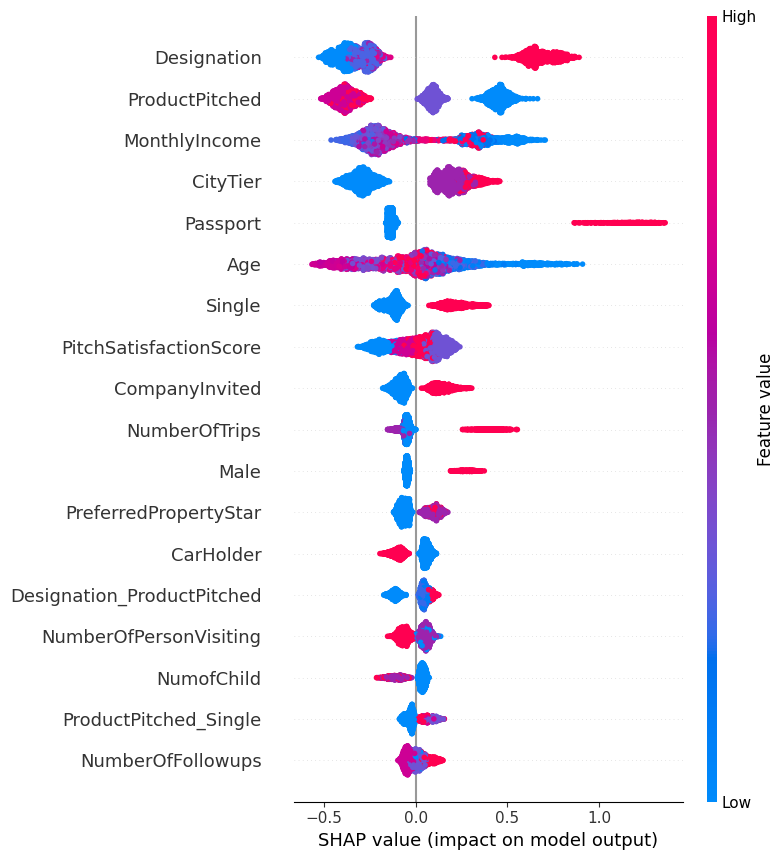

In [106]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
explainer = shap.TreeExplainer(model=models[0])
# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)
# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])
# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

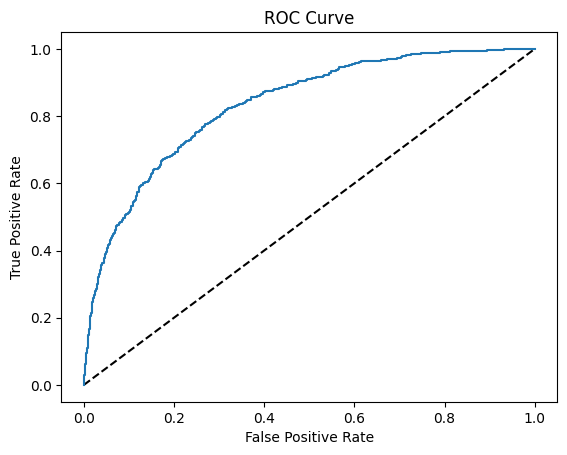

In [107]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [108]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [109]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [110]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)